## XGBoost - viscosity - 2bins - 72/28

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("../plotutils/")
from plotutils import *
plt.style.use("../plotutils/your.mplstyle")
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

In [2]:
df = pd.read_csv(f"../Viscosity_dataset.csv", sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Chemicals                                    100 non-null    object 
 1   SMILES                                       100 non-null    object 
 2   Temperature (kelvin)                         100 non-null    float64
 3   Dynamic Viscosity (cp)                       100 non-null    float64
 4   Classification (based on dynamic viscosity)  100 non-null    object 
 5   viscosity_2bins_5050                         100 non-null    int64  
 6   viscosity_7228                               100 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [3]:
def smiles_to_fingerprint(smiles) -> np.ndarray:
    """
    Convert a SMILES string to a molecular fingerprint using RDKit.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # generate Morgan fingerprint
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=20, fpSize=512)
    fingerprint = mfpgen.GetFingerprint(mol)

    return np.array(fingerprint)

In [4]:
df["mp_bin"] = df["SMILES"].apply(smiles_to_fingerprint)
df["mp_bin"]

0     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
2     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                            ...                        
95    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
96    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
97    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
98    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
99    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: mp_bin, Length: 100, dtype: object

In [25]:
def prepare_dataset_classification(
    df,
    target = "viscosity_7228",
    representation = "mp_bin",
    random_state=42,
    train_size=80
):
    df_train, df_val_test = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=df[target].astype(int).values,
    )
    print(len(df_train), len(df_val_test))
    
    df_val, df_test = train_test_split(
        df_val_test,
        train_size=0.5,
        random_state=random_state,
        stratify=df_val_test[target].astype(int).values,
    )
    print(len(df_val), len(df_test))
    
    X_train, y_train = df_train[representation], df_train[target]
    X_val, y_val = df_val[representation], df_val[target]
    X_test, y_test = df_test[representation], df_test[target]
    
    return list(X_train), y_train, list(X_val), y_val, list(X_test), y_test

In [26]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, random_state=42):
    clf = XGBClassifier(
        #learning_rate = 0.1,
        n_estimators=200, 
        random_state=random_state, 
        early_stopping_rounds=10,
        objective="binary:logistic",
        #use_label_encoder=False, 
        eval_metric="logloss"
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=5)
    
    y_pred = clf.predict(X_test)
    y_test = np.array(y_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [27]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 40

In [46]:
train_size = 40
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [47]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
40 60
30 30
random_state = 42
[0]	validation_0-logloss:0.50193	validation_1-logloss:0.53982
[5]	validation_0-logloss:0.29265	validation_1-logloss:0.39804
[10]	validation_0-logloss:0.21570	validation_1-logloss:0.35424
[15]	validation_0-logloss:0.17864	validation_1-logloss:0.33955
[20]	validation_0-logloss:0.15712	validation_1-logloss:0.32044
[25]	validation_0-logloss:0.14435	validation_1-logloss:0.31191
[30]	validation_0-logloss:0.13161	validation_1-logloss:0.30985
[35]	validation_0-logloss:0.12533	validation_1-logloss:0.30212
[40]	validation_0-logloss:0.12286	validation_1-logloss:0.31034
[43]	validation_0-logloss:0.12190	validation_1-logloss:0.31055
Accuracy: 0.8333333333333334
F1 macro: 0.7545008183306056
F1 micro: 0.8333333333333334
F1 weighted: 0.8194217130387342
Kappa: 0.5161290322580645
-------------Iteration 2/10
40 60
30 30
random_state = 43
[0]	validation_0-logloss:0.49454	validation_1-logloss:0.53104
[5]	validation_0-logloss:0.28115	validation_1-log

In [48]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 40
mean accuracy: 0.7766666666666667 +/- 0.053851648071345064
mean F1 macro: 0.6634257802872132 +/- 0.08293212234778008
mean F1 micro: 0.7766666666666667 +/- 0.053851648071345064
mean F1 weighted: 0.7502271132910042 +/- 0.05755274432682075
mean Kappa: 0.35149706240404016 +/- 0.1530709156126672


In [49]:
compiled_res_40 = pd.DataFrame(metrics_dict())
compiled_res_40.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.833333,0.754501,0.833333,0.819422,0.516129
1,40,"[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.800000,0.687500,0.800000,0.775000,0.391892
2,40,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.725541,0.255319


### training size = 50

In [50]:
train_size = 50
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [51]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
50 50
25 25
random_state = 42
[0]	validation_0-logloss:0.49213	validation_1-logloss:0.55511
[5]	validation_0-logloss:0.27732	validation_1-logloss:0.42639
[10]	validation_0-logloss:0.19656	validation_1-logloss:0.42566
[15]	validation_0-logloss:0.15166	validation_1-logloss:0.45031
[16]	validation_0-logloss:0.14513	validation_1-logloss:0.47111
Accuracy: 0.8
F1 macro: 0.7086247086247086
F1 micro: 0.8
F1 weighted: 0.7804195804195804
Kappa: 0.4292237442922374
-------------Iteration 2/10
50 50
25 25
random_state = 43
[0]	validation_0-logloss:0.50056	validation_1-logloss:0.54630
[5]	validation_0-logloss:0.29419	validation_1-logloss:0.39606
[10]	validation_0-logloss:0.21724	validation_1-logloss:0.38098
[15]	validation_0-logloss:0.18433	validation_1-logloss:0.37683
[17]	validation_0-logloss:0.17522	validation_1-logloss:0.37821
Accuracy: 0.76
F1 macro: 0.5535714285714286
F1 micro: 0.76
F1 weighted: 0.687142857142857
Kappa: 0.19354838709677413
-------------Iteration 3/1

In [52]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 50
mean accuracy: 0.8360000000000001 +/- 0.05782732917920385
mean F1 macro: 0.7633527750013819 +/- 0.10553221235104171
mean F1 micro: 0.8360000000000001 +/- 0.05782732917920385
mean F1 weighted: 0.8202886725803132 +/- 0.07311216305531411
mean Kappa: 0.5410215315698974 +/- 0.19327177893295297


In [53]:
compiled_res_50 = pd.DataFrame(metrics_dict())
compiled_res_50.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,50,"[1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...",0.80,0.708625,0.80,0.780420,0.429224
1,50,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.76,0.553571,0.76,0.687143,0.193548
2,50,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.88,0.844075,0.88,0.877006,0.688797


### training size = 60

In [54]:
train_size = 60
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [55]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
60 40
20 20
random_state = 42
[0]	validation_0-logloss:0.50895	validation_1-logloss:0.52718
[5]	validation_0-logloss:0.30492	validation_1-logloss:0.31463
[10]	validation_0-logloss:0.22125	validation_1-logloss:0.28160
[15]	validation_0-logloss:0.18216	validation_1-logloss:0.27642
[20]	validation_0-logloss:0.16230	validation_1-logloss:0.27165
[25]	validation_0-logloss:0.15239	validation_1-logloss:0.26376
[30]	validation_0-logloss:0.14460	validation_1-logloss:0.26952
[35]	validation_0-logloss:0.13916	validation_1-logloss:0.26932
[36]	validation_0-logloss:0.13784	validation_1-logloss:0.27246
Accuracy: 0.9
F1 macro: 0.8666666666666667
F1 micro: 0.9
F1 weighted: 0.9
Kappa: 0.7333333333333334
-------------Iteration 2/10
60 40
20 20
random_state = 43
[0]	validation_0-logloss:0.48793	validation_1-logloss:0.50448
[5]	validation_0-logloss:0.27671	validation_1-logloss:0.32877
[10]	validation_0-logloss:0.19344	validation_1-logloss:0.30616
[15]	validation_0-logloss:0.1610

In [56]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 60
mean accuracy: 0.8099999999999999 +/- 0.062449979983983994
mean F1 macro: 0.7340590611495783 +/- 0.0883109185261976
mean F1 micro: 0.8099999999999999 +/- 0.062449979983983994
mean F1 weighted: 0.7996667496775255 +/- 0.06337859903424538
mean Kappa: 0.4815009268337442 +/- 0.16704177733777678


In [57]:
compiled_res_60 = pd.DataFrame(metrics_dict())
compiled_res_60.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,60,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.90,0.866667,0.90,0.900000,0.733333
1,60,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.75,0.567100,0.75,0.707792,0.166667
2,60,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.80,0.687500,0.80,0.781250,0.384615


### training size = 70

In [58]:
train_size = 70
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [59]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
70 30
15 15
random_state = 42
[0]	validation_0-logloss:0.50260	validation_1-logloss:0.50482
[5]	validation_0-logloss:0.27693	validation_1-logloss:0.36295
[10]	validation_0-logloss:0.19444	validation_1-logloss:0.33127
[15]	validation_0-logloss:0.16523	validation_1-logloss:0.34578
[20]	validation_0-logloss:0.14646	validation_1-logloss:0.35197
Accuracy: 0.8666666666666667
F1 macro: 0.7916666666666666
F1 micro: 0.8666666666666667
F1 weighted: 0.8499999999999999
Kappa: 0.5945945945945946
-------------Iteration 2/10
70 30
15 15
random_state = 43
[0]	validation_0-logloss:0.49101	validation_1-logloss:0.50365
[5]	validation_0-logloss:0.26287	validation_1-logloss:0.33728
[10]	validation_0-logloss:0.18930	validation_1-logloss:0.27807
[15]	validation_0-logloss:0.15277	validation_1-logloss:0.30743
[19]	validation_0-logloss:0.14090	validation_1-logloss:0.29339
Accuracy: 0.8666666666666667
F1 macro: 0.7916666666666666
F1 micro: 0.8666666666666667
F1 weighted: 0.84999999999

In [60]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 70
mean accuracy: 0.8333333333333333 +/- 0.09545214042184237
mean F1 macro: 0.7751616987131862 +/- 0.11270058627698719
mean F1 micro: 0.8333333333333333 +/- 0.09545214042184237
mean F1 weighted: 0.8264492793247941 +/- 0.09191706833524468
mean Kappa: 0.562792084621349 +/- 0.21621981004723906


In [61]:
compiled_res_70 = pd.DataFrame(metrics_dict())
compiled_res_70.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,70,"[0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.866667,0.791667,0.866667,0.85,0.594595
1,70,"[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",0.866667,0.791667,0.866667,0.85,0.594595
2,70,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]",1.000000,1.000000,1.000000,1.00,1.000000


### training size = 80

In [62]:
train_size = 80
iterations = 10
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [63]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset_classification(
        df,
        random_state=random_state,
        train_size=train_size
    )
    print(f"random_state = {random_state}")

    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val,
        X_test, 
        y_test, 
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)    
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy: {acc}")
    print(f"F1 macro: {f1_macro}")
    print(f"F1 micro: {f1_micro}")
    print(f"F1 weighted: {f1_weighted}")
    print(f"Kappa: {kappa}")

-------------Iteration 1/10
80 20
10 10
random_state = 42
[0]	validation_0-logloss:0.47400	validation_1-logloss:0.50003
[5]	validation_0-logloss:0.24530	validation_1-logloss:0.31903
[10]	validation_0-logloss:0.17397	validation_1-logloss:0.25641
[15]	validation_0-logloss:0.14571	validation_1-logloss:0.24568
[20]	validation_0-logloss:0.13041	validation_1-logloss:0.25638
[25]	validation_0-logloss:0.11942	validation_1-logloss:0.26083
Accuracy: 0.8
F1 macro: 0.6875
F1 micro: 0.8
F1 weighted: 0.7625
Kappa: 0.41176470588235303
-------------Iteration 2/10
80 20
10 10
random_state = 43
[0]	validation_0-logloss:0.48640	validation_1-logloss:0.47410
[5]	validation_0-logloss:0.25552	validation_1-logloss:0.24927
[10]	validation_0-logloss:0.17704	validation_1-logloss:0.22274
[15]	validation_0-logloss:0.15027	validation_1-logloss:0.20068
[20]	validation_0-logloss:0.13515	validation_1-logloss:0.20687
[24]	validation_0-logloss:0.12576	validation_1-logloss:0.21560
Accuracy: 0.8
F1 macro: 0.6875
F1 micro:

In [64]:
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

FINAL REPORT for training size = 80
mean accuracy: 0.79 +/- 0.12206555615733702
mean F1 macro: 0.6928385585003232 +/- 0.1634574948654841
mean F1 micro: 0.79 +/- 0.12206555615733702
mean F1 weighted: 0.7598787438052144 +/- 0.1303810582385581
mean Kappa: 0.42325186367453166 +/- 0.2968507379151063


In [65]:
compiled_res_80 = pd.DataFrame(metrics_dict())
compiled_res_80.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,80,"[0, 0, 0, 1, 0, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0.8,0.6875,0.8,0.7625,0.411765
1,80,"[0, 0, 1, 0, 0, 1, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",0.8,0.6875,0.8,0.7625,0.411765
2,80,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 1]","[0, 0, 0, 1, 1, 0, 0, 0, 0, 1]",1.0,1.0000,1.0,1.0000,1.000000


In [66]:
compiled_res = pd.concat([
    compiled_res_40, 
    compiled_res_50,
    compiled_res_60,
    compiled_res_70,
    compiled_res_80,
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

50


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.833333,0.754501,0.833333,0.819422,0.516129
1,40,"[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.800000,0.687500,0.800000,0.775000,0.391892
2,40,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.725541,0.255319
3,40,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, ...",0.766667,0.712722,0.766667,0.762517,0.426230
4,40,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.833333,0.794802,0.833333,0.830369,0.590164


In [67]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [68]:
compiled_res.to_csv("XGBoost_results_viscosity_2bins_7228.csv", sep=",", index=False)

In [69]:
df = pd.read_csv("XGBoost_results_viscosity_2bins_7228.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   50 non-null     int64  
 1   y_true       50 non-null     object 
 2   y_pred       50 non-null     object 
 3   accuracy     50 non-null     float64
 4   f1_macro     50 non-null     float64
 5   f1_micro     50 non-null     float64
 6   f1_weighted  50 non-null     float64
 7   kappa        50 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.2+ KB


In [70]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",0.833333,0.754501,0.833333,0.819422,0.516129
1,40,"[0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0.800000,0.687500,0.800000,0.775000,0.391892
2,40,"[1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.766667,0.610390,0.766667,0.725541,0.255319


In [71]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
40          0.776667  0.017951  0.663426  0.027644  0.776667  0.017951   
50          0.836000  0.019276  0.763353  0.035177  0.836000  0.019276   
60          0.810000  0.020817  0.734059  0.029437  0.810000  0.020817   
70          0.833333  0.031817  0.775162  0.037567  0.833333  0.031817   
80          0.790000  0.040689  0.692839  0.054486  0.790000  0.040689   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
40            0.750227  0.019184  0.351497  0.051024  
50            0.820289  0.024371  0.541022  0.064424  
60            0.799667  0.021126  0.481501  0.055681  
70            0.826449  0.030639  0.562792  0.072073  
80            0.759879  0.043460  0.423252  0.098950

In [72]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.94285714 0.05714286]
 [0.56666667 0.43333333]]
accuracy: 0.79


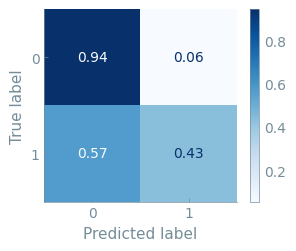

In [73]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".2f")
#plt.savefig('classif_viscosity_confusionMatrix_72_28_size80_XGBoost.pdf', bbox_inches='tight')